# Get all the necessary data in order to visualize

#### for testing purposes, I just download 10 tickers
#### you could download more or download tickers according to your needs

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
# now just read the html to get all the S&P500 tickers 
dataload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = dataload[0]
# now get the first column(tickers) from the above data
# convert it into a list
ticker_list = df['Symbol'][25:35].values.tolist()
all_tickers = " ".join(ticker_list)
# get all the tickers from yfinance
tickers = yf.Tickers(all_tickers)
# set a start and end date to get two-years info
# group by the ticker
hist = tickers.history(start='2020-05-01', end='2022-05-01', group_by='ticker')
stock_data = pd.DataFrame(hist.stack(level=0).reset_index().rename(columns = {'level_1':'Ticker'}))
stock_data['DailyReturn'] = stock_data.sort_values(['Ticker', 'Date']).groupby('Ticker')['Close'].pct_change()
# add the column for moving average daily return, set the moving days to 100 days
stock_data['MovingAverageDailyReturn'] = stock_data.sort_values(['Ticker', 'Date']).groupby('Ticker')['DailyReturn'].rolling(100).mean().reset_index(0,drop=True) 
# Add a column containing the 100days moving average volume
stock_data['MovingAverageVolume'] = stock_data.sort_values(['Ticker', 'Date']).groupby('Ticker')['Volume'].rolling(100).mean().reset_index(0,drop=True)

[*********************100%***********************]  5 of 5 completed


In [3]:
# Calculate the volume-weighted daily returns
stock_data['VWDR'] = np.nan  # 

# function that calculates the volume weighted daily returns
# input should be the dataframe
def func_data(x):
    x['test'] = x['Volume'] * x['DailyReturn'] / x['Volume'].cumsum()
    return x
# create a new column of volume-weighted daily returns, groupby ticker, and apply the above function
stock_data['VWDR'] = stock_data.groupby(['Ticker']).apply(func_data).iloc[:, -1]

#### Transaction Table
##### This table contains the my portfolio's trading information

In [4]:
# create a reference data table, containing some useful information of 10 tickers
reference_table = pd.DataFrame.from_dict({k: [yf.Ticker(ticker).info[k] for ticker in ticker_list] \
                                           for k in ['symbol', 'longName']})
reference = reference_table.rename(columns={'symbol': 'Ticker', 'longName': 'Company'})

# create a transaction table; The transactions span over 2-year period
transactions = {'Date':['2020-05-26', '2020-05-27', '2020-07-30', '2021-01-18', '2021-03-17', '2021-05-21', '2021-09-30', '2021-11-22', '2021-12-06'
                       , '2022-01-06', '2022-02-14'], 
                'Ticker': ['AMZN', 'GOOG', 'AMD', 'AMT', 'AMCR', 'AXP', 'GOOG', 'MO', 'AEP', 'AAL', 'AMZN'],
               'Amount': [+2000, +2000, +1000, -2000, +1000, +2000, -1000, +1000, +1000, +2000, +1000],
                'Buy/Sell': ['Buy', 'Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Buy']
               }
transactions_table = pd.DataFrame(transactions)
transactions_table['Date'] = pd.to_datetime(transactions_table['Date'])  
transactions_table['Position'] = transactions_table.groupby('Ticker')['Amount'].cumsum()

In [5]:
def create_join_table(date):
    # merge the transaction table with the reference table on Ticker, this is to get the company's name for each ticker
    with_company_name = pd.merge(transactions_table[['Date', 'Ticker', 'Position']], reference[['Ticker', 'Company']], on=['Ticker'])
    # now group by the Date and Ticker with the merge list, and filter through the Date less than the date passed-in
    transaction_with_date = with_company_name.groupby(['Date', 'Ticker']).filter(lambda x: x.Date <= date)
    # This is to make sure that the function will drop the ticker with Position <=0 (in case we sell the stock later)
    transaction_to_drop = transaction_with_date[(transaction_with_date['Position'] <= 0)]
    drop_list = transaction_to_drop['Ticker'].tolist()
    if transaction_to_drop.shape[0] != 0:  # if we really have something in the transaction_to_drop
        #drop the transations with negative position values
        transaction_with_date.drop(transaction_with_date[(transaction_with_date['Position'] <= 0)].index, inplace=True)
        #drop all other occurrences of the transactions to drop
        for item in drop_list:
            transaction_with_date.drop(transaction_with_date[(transaction_with_date['Ticker'] == item)].index, inplace=True)
    # drop the first ticker, keep the last one (make it unique)
    transaction_with_date.drop_duplicates(subset='Ticker', keep='last', inplace=True, ignore_index=False)
    # pass the date entered to the transaction filter table
    transaction_with_date['Date']= date
    # convert the date to datetime (make sure it's datetime rather than object)
    transaction_with_date['Date'] = pd.to_datetime(transaction_with_date['Date'])
    # filter the stock historical data table to get the info on the date passed-in (do a filter)
    stock_with_date = stock_data.groupby(['Date', 'Ticker']).filter(lambda x: x.Date == date)
    # finally join the two list on inner
    join_list = transaction_with_date.merge(stock_with_date[['Date','Ticker', 'Open', 'Volume', 'DailyReturn']], on = ['Date','Ticker'], how='inner')
    return join_list

#### Scaffold Table
##### scaffold table contains both my portfolio's info and the tickers' info on specific date
##### this is a time-series data table

In [6]:
# now create a ‘scaffold’ table, which is the concatenation of the above function
# for every business date over the two-year period.
import numpy as np
res = []  # initialize an empty result list to append the result later
date_list = stock_data.Date.tolist()  # store the date from historical data table over two years to the date_list
x = np.array(date_list)  # make the list an array
unique_date_list = np.unique(x)  # we only include the unique date here
for date in unique_date_list:  # using the for loop to append each dataframe result to the list
    res.append(create_join_table(date))
scaffold_table = pd.concat(res, ignore_index=True)  # concate the result list finally
scaffold_table['Daily PnL'] = scaffold_table['DailyReturn'] * scaffold_table['Position']
scaffold_table['Cumulative PnL/Ticker'] = scaffold_table.groupby(['Ticker'])['Daily PnL'].cumsum()

# Plotly Express Visualization

In [7]:
import plotly.express as px
from plotly.subplots import make_subplots

#### Plot the volume-weighted average returns using a line chart

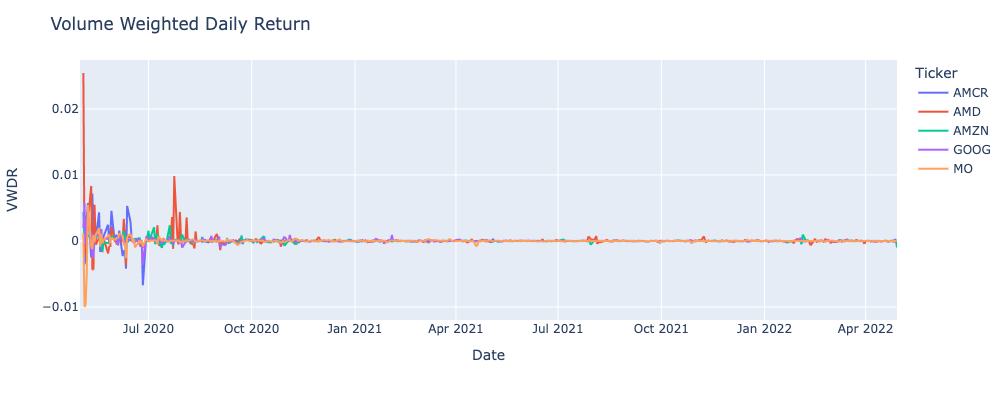

In [8]:
# color parameter should be each ticker, and we set the width and height to accomendate the screen size
fig = px.line(stock_data.reset_index(), x='Date', y="VWDR",color='Ticker', width=800, height=400)
# give a title to the plot
fig.update_layout(
    title_text="Volume Weighted Daily Return",
)
fig.show()

##### It becomes even easier with the plotly express
##### instead of iterating through the list, we have color parameter now to just pass in each ticker
##### we are able to now visualize all the data on the same plot

#### Moving Average Daily Return Using Line Chart

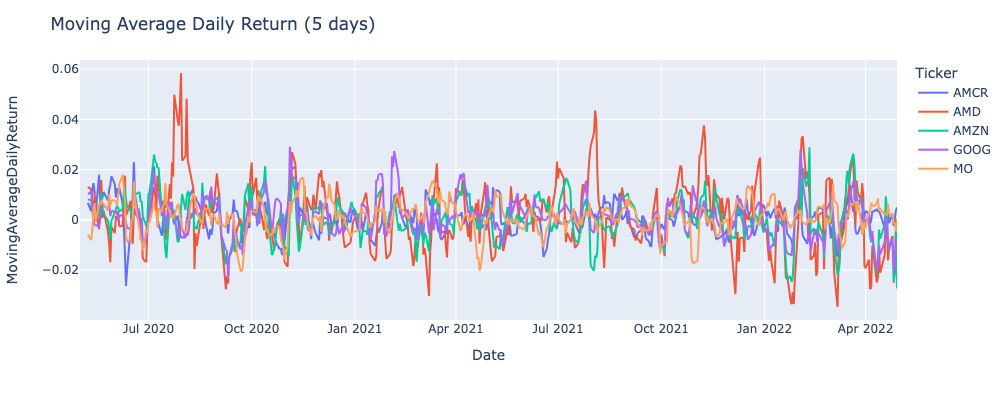

In [9]:
# color parameter should be each ticker, and we set the width and height to accomendate the screen size
fig = px.line(stock_data.reset_index(), x='Date', y="MovingAverageDailyReturn",color='Ticker', width=800, height=400)
# give a title to the plot
fig.update_layout(
    title_text="Moving Average Daily Return (5 days)",
)
fig.show()

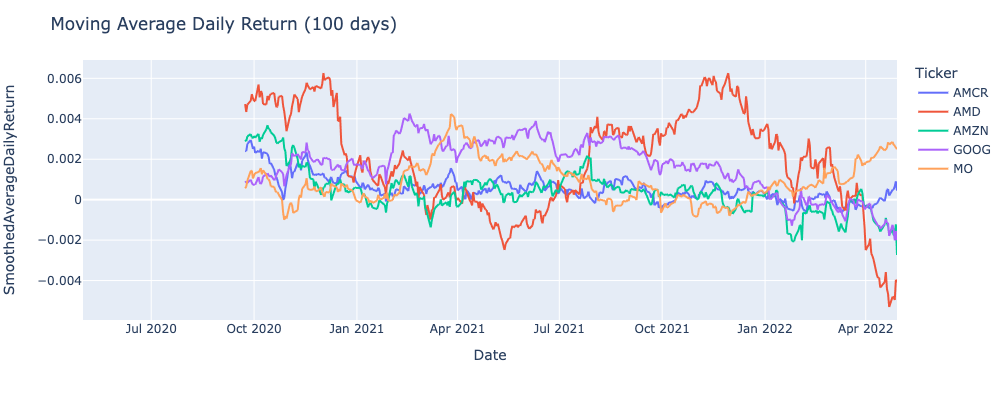

In [10]:
# now try using different moving windows
# use rolling days of 100 instead of 5
# color parameter should be each ticker, and we set the width and height to accomendate the screen size
stock_data['SmoothedAverageDailyReturn'] = stock_data.sort_values(['Ticker', 'Date']).groupby('Ticker')['DailyReturn'].rolling(100).mean().reset_index(0,drop=True)
fig = px.line(stock_data.reset_index(), x='Date', y="SmoothedAverageDailyReturn",color='Ticker', width=800, height=400)
# give a title to the plot
fig.update_layout(
    title_text="Moving Average Daily Return (100 days)",
)
fig.show()

#### Overlay the above 2 plots on the same plot
#### Ticker List Overview

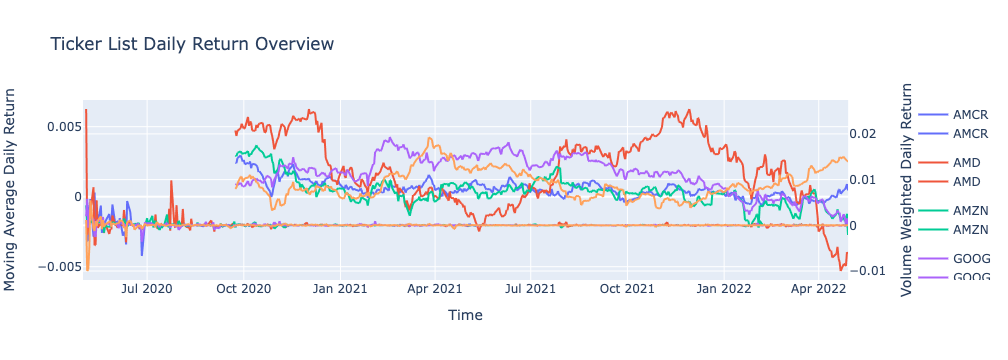

In [11]:
# make subplots to have a secondary y-axis
subfig = make_subplots(specs=[[{"secondary_y": True}]])
# create two figures
fig = px.line(stock_data.reset_index(), x='Date', y="SmoothedAverageDailyReturn",color='Ticker', width=800, height=400)
fig2 = px.line(stock_data.reset_index(), x='Date', y="VWDR",color='Ticker', width=800, height=400)
fig2.update_traces(yaxis="y2")
# add two traces
subfig.add_traces(fig.data + fig2.data)
# set the title for x and y axes
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="Moving Average Daily Return"
subfig.layout.yaxis2.title="Volume Weighted Daily Return"

subfig.update_layout(
    title_text="Ticker List Daily Return Overview",
)
subfig.show()

#### Moving Average Volume

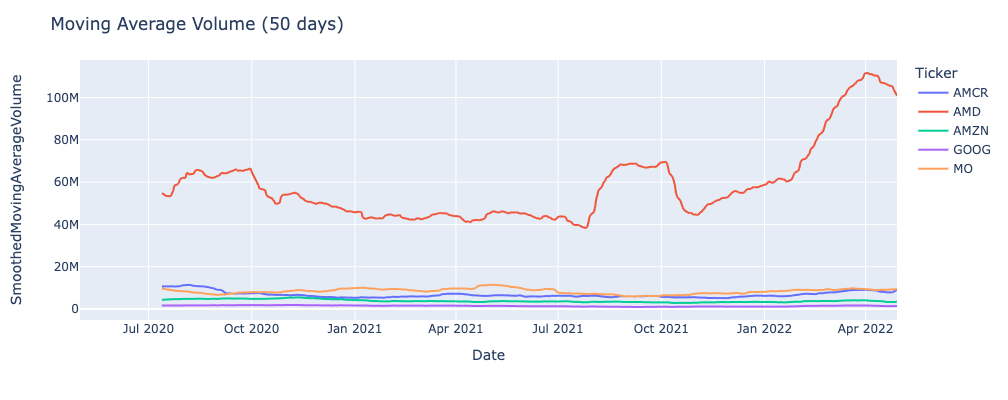

In [14]:
# another line chart with Date as x-axis, and moving average volume as the y-axis
# color parameter is for each ticker
# try using different moving windows
# use rolling days of 50 instead of 5
stock_data['SmoothedMovingAverageVolume'] = stock_data.sort_values(['Ticker', 'Date']).groupby('Ticker')['Volume'].rolling(50).mean().reset_index(0,drop=True)
fig = px.line(stock_data.reset_index(), x='Date', y="SmoothedMovingAverageVolume",color='Ticker', width=800, height=400)
fig.update_layout(
    title_text="Moving Average Volume (50 days)",
)
fig.show()

#### The Two-year Distribution Plot of Daily Volume

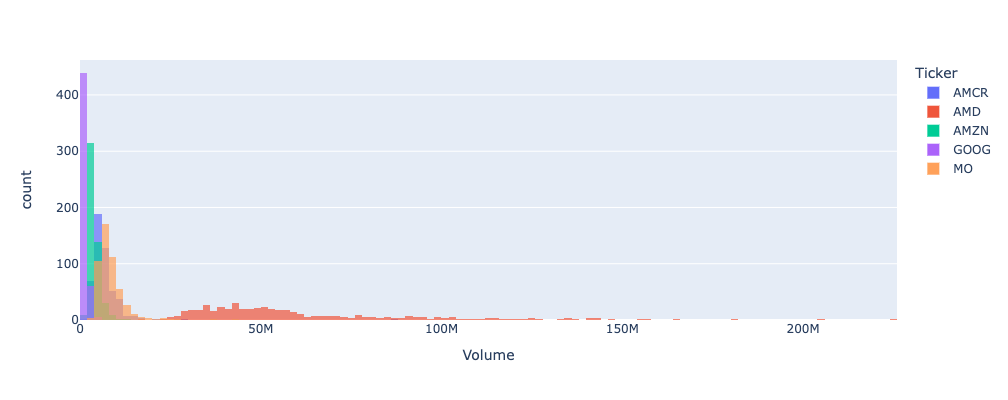

In [15]:
# create a histogram to see the daily volume distribution of all tickers over the two year
# set the bins to 200
fig = px.histogram(stock_data, x="Volume", color='Ticker', nbins=200, opacity=0.7, width=800, height=400,barmode='overlay') # histfunc
fig.show()

#### The Year One Distribution Plot of Daily Volume

In [16]:
# Plot the distribution of daily volume for each of the two years
# get the year1 first
year1 = (stock_data.Date > '2020-05-01') & (stock_data.Date <= '2021-05-01')
year1_data = stock_data.loc[year1]
year1_data.reset_index()
# now get the year2
year2 = (stock_data.Date > '2021-05-01')
year2_data = stock_data.loc[year2]
year2_data.reset_index()

index       Date Ticker        Close  Dividends         High  \
0      1260 2021-05-03   AMCR    11.333621        0.0    11.448976   
1      1261 2021-05-03    AMD    78.550003        0.0    82.000000   
2      1262 2021-05-03   AMZN  3386.489990        0.0  3486.649902   
3      1263 2021-05-03   GOOG  2395.169922        0.0  2419.699951   
4      1264 2021-05-03     MO    45.800320        0.0    46.046509   
...     ...        ...    ...          ...        ...          ...   
1255   2515 2022-04-29   AMCR    11.860000        0.0    12.280000   
1256   2516 2022-04-29    AMD    85.519997        0.0    91.790001   
1257   2517 2022-04-29   AMZN  2485.629883        0.0  2615.219971   
1258   2518 2022-04-29   GOOG  2299.330078        0.0  2379.199951   
1259   2519 2022-04-29     MO    55.570000        0.0    56.990002   

              Low         Open  Stock Splits    Volume  DailyReturn  \
0       11.266331    11.295169             0   7715100     0.003404   
1       78.459999    81.970001             0  66323300    -0.037613   
2     3372.699951  3484.729980             0   5875500    -0.023340   
3     2384.500000  2402.719971             0   1689400    -0.006203   
4       45.213258    45.516258             0   7771300     0.012984   
...           ...          ...           ...       ...          ...   
1255    11.810000    12.190000             0  17666700    -0.023064   
1256    85.379997    88.050003             0  82568500    -0.045962   
1257  2432.500000  2596.979980             0  13616500    -0.140494   
1258  2293.879883  2351.560059             0   1683500    -0.037224   
1259    55.529999    55.950001             0  10861600     0.006703   

      MovingAverageDailyReturn  MovingAverageVolume      VWDR  \
0                     0.000898            6795820.0  0.000014   
1                    -0.016504           67009980.0 -0.000191   
2                    -0.001253            5805240.0 -0.000126   
3                     0.005956            2041840.0 -0.000025   
4                     0.004904            9151580.0  0.000043   
...                        ...                  ...       ...   
1255                  0.004969           17721820.0 -0.000116   
1256                 -0.005047           87959480.0 -0.000125   
1257                 -0.027310            6003860.0 -0.000980   
1258                 -0.007312            2166140.0 -0.000085   
1259                  0.000158            9203980.0  0.000017   

      SmoothedAverageDailyReturn  SmoothedMovingAverageVolume  
0                       0.000586                    6316530.0  
1                      -0.001474                   45837724.0  
2                       0.000818                    3618340.0  
3                       0.002903                    1508068.0  
4                       0.001978                   11414384.0  
...                          ...                          ...  
1255                    0.000447                    8908882.0  
1256                   -0.004076                  100982200.0  
1257                   -0.002734                    3572036.0  
1258                   -0.002007                    1429578.0  
1259                    0.002507                    9442108.0  

[1260 rows x 16 columns]

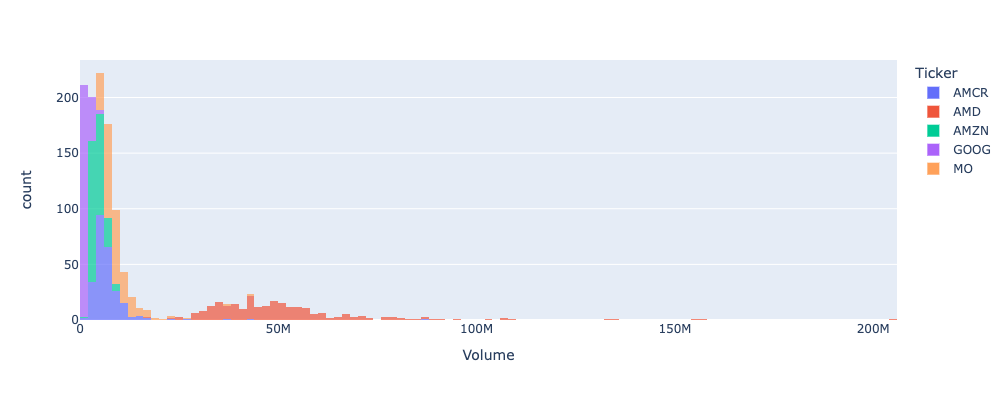

In [17]:
# create a histogram to see the daily volume distribution of all tickers for year one
# set the bins to 200
fig = px.histogram(year1_data, x="Volume", color='Ticker', nbins=200, opacity=0.7, width=800, height=400) # histfunc
fig.show()

#### The Year Two Distribution Plot of Daily Volume

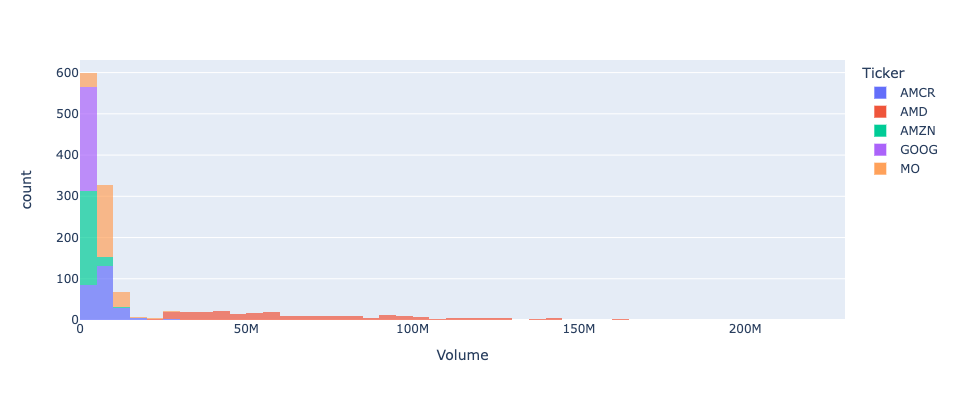

In [18]:
# create a histogram to see the daily volume distribution of all tickers for year two
# set the bins to 200
fig = px.histogram(year2_data, x="Volume", color='Ticker', nbins=50, opacity=0.7, width=800, height=400) # histfunc
fig.show()

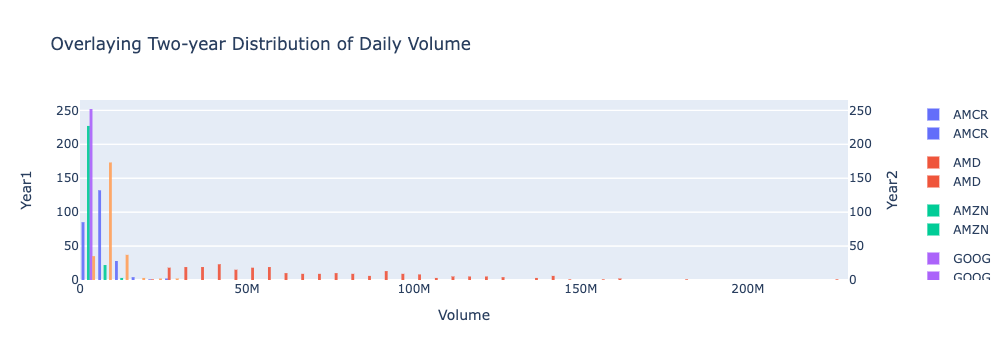

In [19]:
# make subplots to have a secondary y-axis
subfig = make_subplots(specs=[[{"secondary_y": True}]])
# create two figures
fig = px.histogram(year2_data.reset_index(), x="Volume", color='Ticker', nbins=50, opacity=0.7, width=800, height=400,barmode='overlay')
fig2 = px.histogram(year2_data.reset_index(), x="Volume", color='Ticker', nbins=50, opacity=0.7, width=800, height=400,barmode='overlay')
fig2.update_traces(yaxis="y2")
# add two traces
subfig.add_traces(fig.data + fig2.data)
# set the title for x and y axes
subfig.layout.xaxis.title="Volume"
subfig.layout.yaxis.title="Year1"
subfig.layout.yaxis2.title="Year2"

subfig.update_layout(
    title_text="Overlaying Two-year Distribution of Daily Volume",
)
subfig.show()

#### cumulative PnL for each ticker from my portfolio

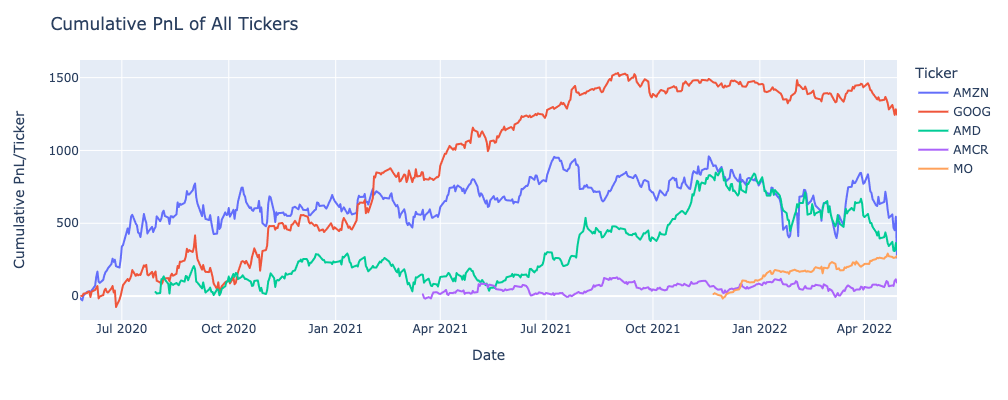

In [20]:
# color parameter should be each ticker, and we set the width and height to accomendate the screen size
fig = px.line(scaffold_table.reset_index(), x='Date', y="Cumulative PnL/Ticker",color='Ticker', width=800, height=400)
# give a title to the plot
fig.update_layout(
    title_text="Cumulative PnL of All Tickers",
)
fig.show()

#### another way using pivot table
##### color parameter is much more efficient and powerful with plotly express!

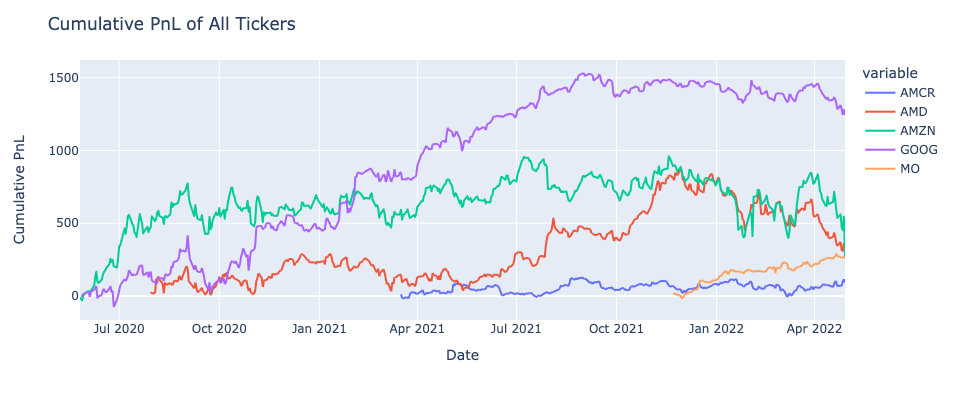

In [21]:
# utilize pivot table in order to plot multiple tickers on the same plot
pivoted = scaffold_table.reset_index().pivot(index='Date', columns='Ticker', values='Cumulative PnL/Ticker')
# pivot date, ticker and the PnL
# now pass the pivot table into px.line, reset index, set x to Date and y to the columns
fig = px.line(pivoted.reset_index(), x='Date', y=pivoted.columns, width=800, height=400)
# create title for y-axis and the plot
fig.layout.yaxis.title="Cumulative PnL"
fig.update_layout(
    title_text="Cumulative PnL of All Tickers",
)
fig.show()

#### Scatter plot of PnL per ticker, year1 vs year2

In [22]:
# Create a scatter plot of PnL per ticker, year1 vs year2 (year1 as y-axis, year2 as x-axis)
# In this program, compare the PnL of Ticker AMZN
# extract the data from the original scaffold table
AMZN = scaffold_table[scaffold_table.Ticker=='AMZN']

# separate the year 1 and year 2 table with each ticker table
year1_AMZN = (AMZN.Date > '2020-05-01') & (AMZN.Date < '2021-05-13')
year1_AMZN_data = AMZN.loc[year1_AMZN]

year2_AMZN = (AMZN.Date >= '2021-05-13')
year2_AMZN_data = AMZN.loc[year2_AMZN]

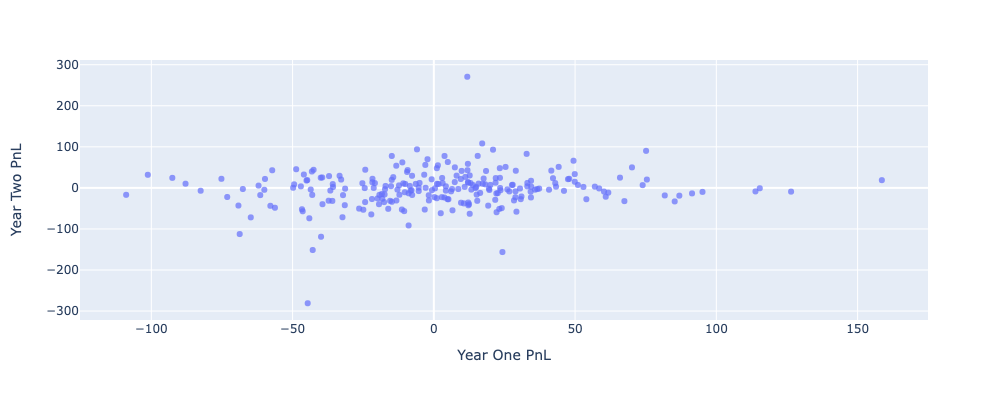

In [23]:
# make a scatter with x of year1 PnL, y of year2 PnL
fig = px.scatter(x=year1_AMZN_data['Daily PnL'], y=year2_AMZN_data['Daily PnL'],width=800, height=400, opacity=.7)
# Set the title for x and y axis
fig.layout.yaxis.title="Year Two PnL"
fig.layout.xaxis.title="Year One PnL"

fig.show()